[Preliminary Analysis]
1. Access Post-processed interpolated daily fire perimeters 
2. Intersect each fire with ADS_10_19: Merged ADS Tree Mortality dataset 
3. Calculate % area of tree mortality per area burned 
    <% tree mortality = Area (ha) of TM / Total Area Burned]>
4. Compare with area burned per day 
5. Compare with rate of spread per day 

[Prediction]
1. Buffer day in advance see how much % mortality from the fire-line 
2. Use into model input 

In [1]:
import arcpy
from arcpy import env
from arcpy.sa import *
arcpy.overwriteoutput = True

env.workspace = "F:\DriversFireProject\TEMP"

In [2]:
import shutil
import pandas as pd
from datetime import datetime, date, time, timedelta
import requests
import zipfile
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
# get list of files based on directory and extension inputs 
def shpFiles(rootPath, ext):
    emptyList = []
    root = rootPath
    for path, subdirs, files in os.walk(root):
        for names in files: 
            if names.endswith(ext) and not names.startswith("._"):
                emptyList.append(path + '\\' + names)
    return(emptyList)

# Create new folder in root path 
def createFolder(rootPath, folderName): 
    folderPath = os.path.join(rootPath, folderName) 
    if not os.path.exists(folderPath):
        os.makedirs(folderPath)
    return folderPath + "\\" 

In [4]:
# calculate total area burned (ha) for simplified interpolated surface 
rootPath = r'F:\DriversFireProject\NaturalNeighborResults\Daily'
simp = os.path.join(rootPath, 'SimplifiedSHP')
interFiles = shpFiles(simp, '.shp')
mergedADS = r'F:\TreeMortality\ADS_Dataset\Merged\Merged_ADS_10_19.shp'

for inter in interFiles: 
    # set up new lists per fire 
    fire = []
    year = [] 
    jd = [] 
    rptYr = [] 
    totalBurned = [] 
    tmArea = [] 
    # get fireName, year from path name 
    nm = inter.split("\\")
    name = nm[-1]
    nmm = name.split("_")
    fr = nmm[0]
    yr = nmm[1]
    print(yr, fr)
    
    # Calculate TOTAL burned area (ha) 
    arcpy.DeleteField_management(inter, "BurnedArea")
    arcpy.AddField_management(inter, "BurnedArea", "DOUBLE")
    arcpy.CalculateField_management(inter, "BurnedArea", "!shape.area@HECTARES!", "PYTHON", "")
    
    # Set up new folders 
    outpath = r'F:\TreeMortality\DailyFireIntersects'
    yrFolder = createFolder(outpath, str(yr))
    frFolder = createFolder(yrFolder, fr)
    
    # Intersect merged ADS with each fire perimeters 
    intersect = arcpy.Intersect_analysis([inter, mergedADS], frFolder + name)
    
    # Calculate area of Tree Mortality per day 
    arcpy.AddField_management(intersect, "TMArea", "DOUBLE")
    arcpy.CalculateField_management(intersect, "TMArea", "!shape.area@HECTARES!", "PYTHON", "")
    with arcpy.da.SearchCursor(intersect, ['BurnedArea', 'TMArea', 'gridcode', 'RPT_YR']) as cursor:
        for row in cursor:
            fire.append(fr)
            year.append(yr)
            rptYr.append(row[3])
            totalBurned.append(row[0])
            jd.append(row[2])
            tmArea.append(row[1])
    
    # Create DF
    multiDirDF = pd.DataFrame({'Fire': fire, 'FR_Year': year,'FR_Day':jd, 
                               'TM_Year': rptYr, 'Burned_Area(ha)': totalBurned, 'TM_Area(ha)': tmArea})
    
    # Groupby Fire, Fr_year, Fr_Day, TM_Year, Burned_Area(ha) >> aka ADD up TM_AREA per RPTYEAR 
    grouped = multiDirDF.groupby(['Fire', 'FR_Year', 'FR_Day', 'TM_Year', 'Burned_Area(ha)'])['TM_Area(ha)'].agg('sum').reset_index()
    # Calculate ratio TM_AREA(ha) / Burned_AREA(ha) 
    grouped['TM_Ratio'] = grouped['TM_Area(ha)'] / grouped['Burned_Area(ha)']
    
    CSVPath = r'F:\TreeMortality\CSV_TMPerFire'
    yrCSVFolder = createFolder(CSVPath, str(yr))
    grouped.to_csv(yrCSVFolder + fr + "_" + str(yr) + '_TM.csv') 
    
    # pivot Table 
    grouped['TM_Year'] = grouped['TM_Year'].astype(str)
    PIVtable = pd.pivot_table(grouped, values=['TM_Area(ha)', 'TM_Ratio'], index=['Fire', 'FR_Year', 'FR_Day', 'Burned_Area(ha)'],
                        columns=['TM_Year'], aggfunc=np.sum).reset_index()

    PIVtable.columns = [' '.join(col).strip() for col in PIVtable.columns.values]

    CSVPath2 = r'F:\TreeMortality\CSV_TMPerFire_PIV'
    yrCSVFolder2 = createFolder(CSVPath2, str(yr))
    
    PIVtable.to_csv(yrCSVFolder2 + fr + "_" + str(yr) + '_TMPIV.csv')         
        
            


2012 Bagleycomplex
2012 Banner
2012 Chihuahua2
2012 Chips
2012 Dale
2012 Fortcomplex
2012 Fortcomplexgoff
2012 George
2012 Highland
2012 Jawbonecomplex
2012 Likely
2012 Mdflakecomplex
2012 Northpass
2012 Pass
2012 Piutecomplexclear
2012 Ramsey
2012 Reading
2012 Robbers
2012 Rush
2012 Rushfire
2012 Scotts
2012 Shockey
2012 Sitescomplex
2012 Sixteen
2012 Sixteencomplex
2012 Turkey
2012 Vallecitolightningcomplexstewart
2012 Vallecitolightningcomplexwilson
2012 Williams
2012 Wye
2013 American
2013 Aspen
2013 Butler
2013 Carstens
2013 Chariot
2013 Clover
2013 Corralcomplexcorral
2013 Deluz
2013 Falls
2013 Felipe
2013 General
2013 Grand
2013 Hathaway
2013 Mccabe
2013 Morgan
2013 Mountain
2013 Panther
2013 Powerhouse
2013 Rim
2013 Salmonrivercomplexboulder
2013 Salmonrivercomplexshelly
2013 Silver
2013 Swedes
2013 White
2014 Basilonecomplexcombat
2014 Basilonecomplexpulgas
2014 Basilonecomplextomahawk
2014 Bully
2014 Butts
2014 Cocos
2014 Coffee
2014 Coffeecomplex
2014 Colby
2014 Darkhole
201

In [44]:
multiDirDF
# Groupby Fire, Fr_year, Fr_Day, TM_Year, Burned_Area(ha) >> aka ADD up TM_AREA per RPTYEAR 
grouped = multiDirDF.groupby(['Fire', 'FR_Year', 'FR_Day', 'TM_Year', 'Burned_Area(ha)'])['TM_Area(ha)'].agg('sum').reset_index()
# Calculate ratio TM_AREA(ha) / Burned_AREA(ha) 
grouped['TM_Ratio'] = grouped['TM_Area(ha)'] / grouped['Burned_Area(ha)']
grouped['TM_Year'] = grouped['TM_Year'].astype(str)
grouped

,Fire,FR_Year,FR_Day,TM_Year,Burned_Area(ha),TM_Area(ha),TM_Ratio
0,Scotts,2012,252,2011,947.277656,1.984406,0.002095
1,Scotts,2012,252,2012,947.277656,3.431592,0.003623
2,Scotts,2012,252,2014,947.277656,34.902443,0.036845
3,Scotts,2012,252,2015,947.277656,0.571608,0.000603
4,Scotts,2012,252,2018,947.277656,0.002813,0.000003


SPLIT csv into BEFORE and AFTER Fire: 
1. [Before]: relationship between how tree mortality affects fires behavior 
2. [After]: relationship between how fire can induce tree mortality (stress) 

In [43]:
# Merge sll piv csv files 
CSVPath = r'F:\TreeMortality\CSV_TMPerFire'
csvFiles = shpFiles(CSVPath, '.csv')
outPath = r'F:\TreeMortality\\'
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in csvFiles])
#export to csv
combined_csv.to_csv( outPath + "MergedALL_TM.csv", index=False, encoding='utf-8-sig')

In [46]:
combined_csv['TM_Year'] = combined_csv['TM_Year'].astype(str)
PIVtable = pd.pivot_table(combined_csv, values=['TM_Ratio'], index=['Fire', 'FR_Year', 'FR_Day', 'Burned_Area(ha)'],
                    columns=['TM_Year'], aggfunc=np.sum).reset_index()

PIVtable = PIVtable.fillna(0)
PIVtable = PIVtable.round(5)
PIVtable.columns = [' '.join(col).strip() for col in PIVtable.columns.values]
PIVtable.to_csv( outPath + "MergedALL_TM_PIV.csv", index=False, encoding='utf-8-sig')

In [55]:
# 1. [Before]: relationship between how tree mortality affects fires behavior 
# Keep rows only where TM_Area IF YM_YEAR is less than equal to FR_Year 
combined_csv['FR_Year'] = combined_csv['FR_Year'].astype('int64')
combined_csv['TM_Year'] = combined_csv['TM_Year'].astype('int64')
combined_csv['Group'] = np.where((combined_csv['FR_Year'] > combined_csv['TM_Year']), 'BeforeFire', 'AfterFire')

In [58]:
TM_BeforeFire = pd.read_csv(outPath + "BeforeFire_TM.csv", index_col=0)

In [60]:
# look at TM YEARS -1 , -3, -all) 
TM_BeforeFire['YearPrior'] = TM_BeforeFire['FR_Year'] - TM_BeforeFire['TM_Year']
TM_BeforeFire

,Fire,FR_Year,FR_Day,TM_Year,Burned_Area(ha),TM_Area(ha),TM_Ratio,Group,YearPrior
Unnamed: 0,,,,,,,,,
2,Bagleycomplex,2012,233,2011,831.816076,22.542806,0.027101,BeforeFire,1
9,Bagleycomplex,2012,234,2010,1025.933322,0.318780,0.000311,BeforeFire,2
10,Bagleycomplex,2012,234,2011,1025.933322,44.391363,0.043269,BeforeFire,1
16,Bagleycomplex,2012,235,2010,1151.103974,0.526336,0.000457,BeforeFire,2
17,Bagleycomplex,2012,235,2011,1151.103974,35.534969,0.030870,BeforeFire,1
...,...,...,...,...,...,...,...,...,...
66,Walker,2019,255,2018,567.131763,0.002813,0.000005,BeforeFire,1
67,Walker,2019,256,2010,103.516643,1.103944,0.010664,BeforeFire,9
68,Walker,2019,257,2011,293.063383,8.210076,0.028015,BeforeFire,8


In [66]:
# one year prior 
onyear = TM_BeforeFire[TM_BeforeFire['YearPrior'] < 1]
onyearGroup = onyear.groupby(['Fire', 'FR_Year', 'FR_Day', 'Burned_Area(ha)'])['TM_Area(ha)'].agg('sum').reset_index()
onyearGroup['TM_Ratio'] = onyearGroup['TM_Area(ha)']/ onyearGroup['Burned_Area(ha)']
onyearGroup

,Fire,FR_Year,FR_Day,Burned_Area(ha),TM_Area(ha),TM_Ratio
0,Adobe,2017,283,113.621988,0.002813,0.000025
1,Alder,2018,292,2.245113,0.416075,0.185325
2,Alder,2018,293,15.715540,2.933994,0.186694
3,Alder,2018,294,11.225271,5.272729,0.469720
4,Alder,2018,295,21.426107,16.239488,0.757930
...,...,...,...,...,...,...
990,Willow,2015,209,256.254469,5.652034,0.022056
991,Willow,2015,210,555.005188,129.811941,0.233893
992,Willow,2015,211,475.727398,134.298411,0.282301
993,Willow,2015,212,224.648747,48.851181,0.217456


C:\Users\erica\AppData\Local\ESRI\conda\envs\my_arcgispro-py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


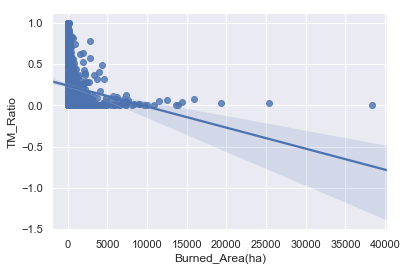

In [78]:
# three years prior
threeYear = TM_BeforeFire[TM_BeforeFire['YearPrior'] < 3]
threeYear = threeYear.groupby(['Fire', 'FR_Year', 'FR_Day', 'Burned_Area(ha)', 'YearPrior'])['TM_Area(ha)'].agg('sum').reset_index()
threeYear['TM_Ratio'] = threeYear['TM_Area(ha)']/ threeYear['Burned_Area(ha)']
threeYear['log_Area'] = np.log(threeYear['Burned_Area(ha)'])

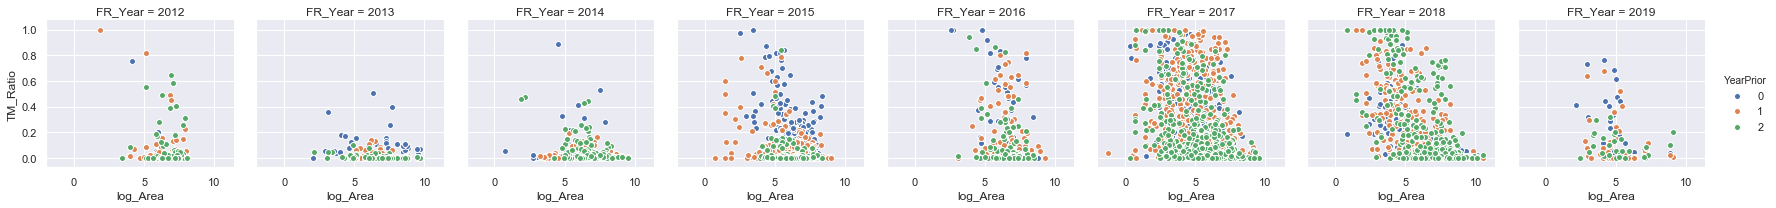

In [81]:
g = sns.FacetGrid(threeYear, col="FR_Year", hue="YearPrior")
g = (g.map(plt.scatter, "log_Area", "TM_Ratio", edgecolor="w")
        .add_legend())

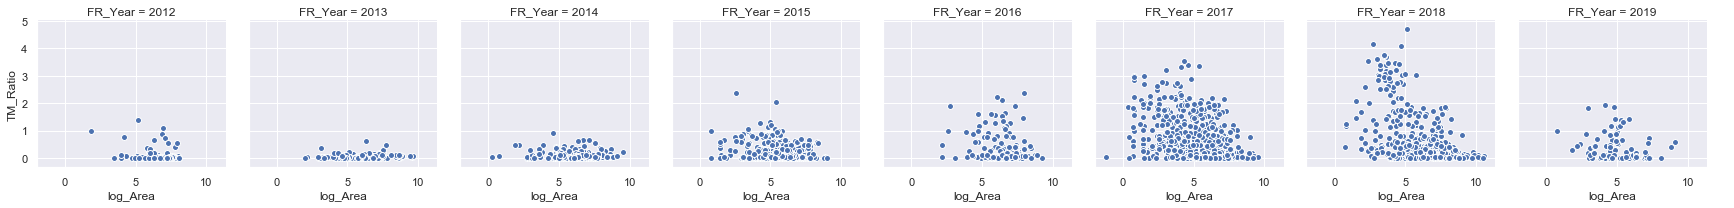

In [85]:
# all years prior 
AllYear = TM_BeforeFire.groupby(['Fire', 'FR_Year', 'FR_Day', 'Burned_Area(ha)'])['TM_Area(ha)'].agg('sum').reset_index()
AllYear['TM_Ratio'] = AllYear['TM_Area(ha)']/ AllYear['Burned_Area(ha)']
AllYear['log_Area'] = np.log(AllYear['Burned_Area(ha)'])

g = sns.FacetGrid(AllYear, col="FR_Year")
g = (g.map(plt.scatter, "log_Area", "TM_Ratio", edgecolor="w")
        .add_legend())

In [93]:
AllYear = TM_BeforeFire.groupby(['Fire', 'FR_Year'])['TM_Area(ha)', 'Burned_Area(ha)'].agg('sum').reset_index()
AllYear['Ratio'] = AllYear['TM_Area(ha)']/ AllYear['Burned_Area(ha)']
AllYear.sort_values(by=['TM_Area(ha)'], ascending=False)

,Fire,FR_Year,TM_Area(ha),Burned_Area(ha),Ratio
65,Ferguson,2018,46376.330691,325626.533400,0.142422
181,Rough,2015,25970.853929,343751.813685,0.075551
24,Cedarsqf,2016,19312.615160,78834.048274,0.244978
162,Pier,2017,19263.028336,103825.926585,0.185532
188,Salmonaugustcomplexwallow,2017,18196.324547,193821.450292,0.093882
...,...,...,...,...,...
138,Mineral,2016,0.186034,1274.209047,0.000146
168,Powerhouse,2013,0.138203,2439.954614,0.000057
197,Shockey,2012,0.088177,816.289819,0.000108
25,Chariot,2013,0.032035,1549.643311,0.000021


In [ ]:
# 2. [After]: relationship between how fire can induce tree mortality (stress) 
TM_AfterFire = pd.read_csv(outPath + "AfterFire_TM.csv", index_col=0)